## This is a quick tutorial on how to use BayLIME to explain an image.

by XZ 05/10/2020

In [1]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import mark_boundaries
from lime import lime_image
import csv
from lime import calculate_posteriors
print('Notebook run using keras:', keras.__version__)

Using TensorFlow backend.


Notebook run using keras: 2.3.1


Same as the original LIME tutorial, we are reusing the pretrained DNN InceptionV3.

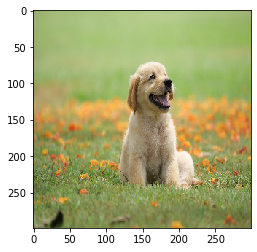

('n02099601', 'golden_retriever', 0.7591777)
('n02099712', 'Labrador_retriever', 0.13248245)
('n02102318', 'cocker_spaniel', 0.015283059)
('n02101556', 'clumber', 0.014689475)
('n02104029', 'kuvasz', 0.0038136626)


In [2]:
#Same as the original LIME tutorial,
#here we create a standard InceptionV3 pretrained model 
#and use it on images by first preprocessing them with the preprocessing tools
inet_model = inc_net.InceptionV3()

def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)


images = transform_img_fn([os.path.join('data','5.jpg')])
# I'm dividing by 2 and adding 0.5 because of
# how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
plt.show()
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

#### Now we create an instance of LIME explainer with an arg _feature_selection='none'_ meaning we will consider all features of the image in our later explanation. You may also specify other args like kernel_width etc. For a complete list of args, cf. the comments in the sources code when defining the class.

In [3]:
explainer = lime_image.LimeImageExplainer(feature_selection='none')#kernel_width=0.1

#### First, let us explain the image _image[0]_ with the original LIME -- i.e. with option _model_regressor='non_Bay'_ .

Meanings behind other args, again, can be found in comments of the source codes when defining the function. E.g., _number_samples=200_ represents the number of perturbed samples used for the training of the local surrogate model.

the number of features: 63


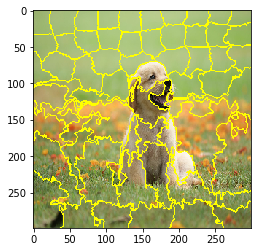


using non_Bay option for model regressor
using non_Bay option for model regressor
using non_Bay option for model regressor


In [4]:
explanation = explainer.explain_instance(images[0], inet_model.predict,
                                         top_labels=3, hide_color=0, batch_size=10,
                                         num_samples=200,model_regressor='non_Bay')
#'non_Bay' 'Bay_non_info_prior' 'Bay_info_prior','BayesianRidge_inf_prior_fit_alpha'

Now we have done the explanations for the top 3 labels. We have different ways to present the explanation results -- to show a few regarding the top label as the following:
1. Showing top 10 features and hide the rest. Also the 10 features could have both positive and negative contribution to the prediction.
2. Only showing the top 5 positive features without hiding the rest.
3. Or we can simply present the 'importance' of each feature as a list.

Note, the mean and variance information for the top 10 features are internal assertions that can be switched off (assuming they are repetitive in some cases). In this case, since we are using non-bay option, there is no mean/variance actually, so you see a 0 variance and mean really represents the fitted coefficient by the Linear Regressor.

For feature of segment 36
The mean of the (posterior) coefficient 0.1512615680372532
The variance of the (posterior) coefficient 0.0
For feature of segment 34
The mean of the (posterior) coefficient 0.13521561874044458
The variance of the (posterior) coefficient 0.0
For feature of segment 29
The mean of the (posterior) coefficient 0.06639963049634717
The variance of the (posterior) coefficient 0.0
For feature of segment 47
The mean of the (posterior) coefficient 0.0637040954037715
The variance of the (posterior) coefficient 0.0
For feature of segment 32
The mean of the (posterior) coefficient 0.05435916643908248
The variance of the (posterior) coefficient 0.0
For feature of segment 53
The mean of the (posterior) coefficient 0.04886483209051087
The variance of the (posterior) coefficient 0.0
For feature of segment 44
The mean of the (posterior) coefficient 0.04702106575753365
The variance of the (posterior) coefficient 0.0
For feature of segment 16
The mean of the (posterior) coefficien

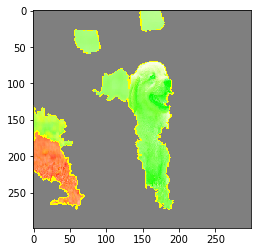

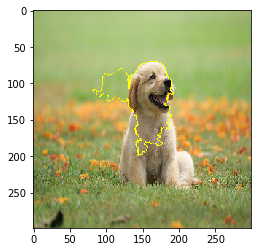

[('36', 0.1512615680372532), ('34', 0.13521561874044458), ('29', 0.06639963049634717), ('47', 0.0637040954037715), ('32', 0.05435916643908248), ('53', 0.04886483209051087), ('44', 0.04702106575753365), ('16', 0.044935314463480536), ('51', -0.04087518090931516), ('5', 0.03933843014963834), ('20', -0.03695878723177401), ('46', 0.03682254811786918), ('14', 0.035591849978648116), ('7', 0.03554497151253811), ('39', 0.03454623172716894), ('26', 0.0334260286918417), ('27', 0.03339179446406912), ('13', 0.03142439358954305), ('23', -0.03049443883098538), ('33', 0.029956759275452192), ('22', -0.02821062417064764), ('18', 0.026305061640443113), ('6', -0.026073330974230587), ('2', 0.02268045068687296), ('24', -0.02258722160426423), ('8', 0.022392853564527807), ('35', 0.02136098251035729), ('25', 0.02091771748284342), ('4', -0.020121667360192108), ('3', 0.018058220525978413), ('43', 0.017704476399098536), ('41', -0.01768474805093102), ('10', 0.01696599751288949), ('19', 0.014947451956591142), ('55'

In [5]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

print(explanation.as_list(explanation.top_labels[0]))

#### Now let us explain the image _image[0]_ with BayLIME but without any prior information -- i.e. with option _model_regressor='Bay_non_info_prior'_ .

Essentially we use a zero mean vector as prior knowledge with fitted precision parameters.

Note, you will see 1 set of fitted alpha and lambda parameters (cf. the BayLIME paper for the meanings of these two parameters..) that corresponds to the explanations to the top 1 label.

the number of features: 63


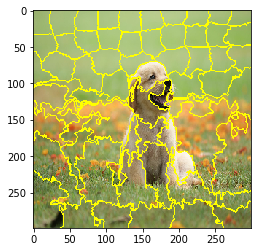


using Bay_non_info_prior option for model regressor
Convergence after  7  iterations
the alpha is 149.3522997258022
the lambda is 1240.9746233689257
the regulation term lambda/alpha is 8.30904261700186


In [6]:
explanation = explainer.explain_instance(images[0], inet_model.predict,
                                         top_labels=1, hide_color=0, batch_size=10,
                                         num_samples=200,model_regressor='Bay_non_info_prior')
#'non_Bay' 'Bay_non_info_prior' 'Bay_info_prior','BayesianRidge_inf_prior_fit_alpha'

##### It is worth to note that the fitted alpha and lambda parameters are recorded in a CSV file './posterior_configure.csv'

For feature of segment 36
The mean of the (posterior) coefficient 0.0889999298819494
The variance of the (posterior) coefficient 0.00024128573526064378
For feature of segment 34
The mean of the (posterior) coefficient 0.08012545038428448
The variance of the (posterior) coefficient 0.00024894106843747306
For feature of segment 29
The mean of the (posterior) coefficient 0.06982819274403902
The variance of the (posterior) coefficient 0.00024279550023469717
For feature of segment 14
The mean of the (posterior) coefficient 0.04277721765828182
The variance of the (posterior) coefficient 0.00024560617169325455
For feature of segment 47
The mean of the (posterior) coefficient 0.0388193234477781
The variance of the (posterior) coefficient 0.00023995530318198836


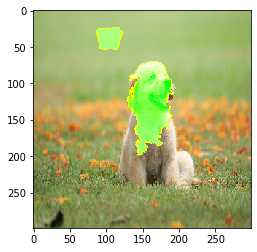

[('36', 0.0889999298819494), ('34', 0.08012545038428448), ('29', 0.06982819274403902), ('14', 0.04277721765828182), ('47', 0.0388193234477781), ('22', 0.03475395105854548), ('61', 0.0341472655949858), ('35', 0.03381441984251274), ('12', 0.030493187144148247), ('18', -0.028302876257445538), ('55', 0.022762695815000077), ('3', 0.02253498026943437), ('10', 0.02215457139063034), ('1', 0.02178877561415247), ('32', 0.02139659060723018), ('21', -0.020164052118147636), ('4', 0.019689869563260964), ('37', 0.01953425423077314), ('15', 0.018058394527917146), ('8', -0.01596158097238345), ('48', -0.01590532875092218), ('2', 0.015081524836394734), ('19', -0.014799970915333421), ('31', 0.014711795035091457), ('54', 0.014585184862191986), ('45', 0.013583606824079131), ('51', 0.013313258883038949), ('33', 0.012936355945152031), ('56', 0.012313473364622188), ('62', 0.01215074046965986), ('58', 0.011887071918191022), ('53', 0.010954573713582584), ('41', 0.010292252722865394), ('0', 0.01008007638443552), 

In [7]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

print(explanation.as_list(explanation.top_labels[0]))

#### Now let us explain the top 1 label of the image _image[0]_ with BayLIME and with full prior knowledge -- i.e. with option _model_regressor='Bay_info_prior'_ .

You will see, in this case, we read the alpha and lambda parameters from the CSV file  './configure.csv'. Moreover, after the explanation, we will again write the parameters into the  './posterior_configure.csv' file.

the number of features: 63


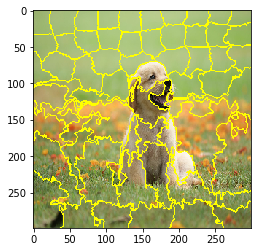


using Bay_info_prior option for model regressor
the alpha is 1.0
the lambda is 20.0
the regulation term lambda/alpha is 20.0


In [8]:
explanation = explainer.explain_instance(images[0], inet_model.predict,
                                         top_labels=1, hide_color=1, batch_size=10,
                                         num_samples=200,model_regressor='Bay_info_prior')

The following code simply reads the values of the alpha and lambda parameters from the CSV file into two variables.

In [10]:
alpha_var=1
lambda_var=1
with open('./posterior_configure.csv') as csv_file:
    csv_reader=csv.reader(csv_file)
    line_count = 0
    for row in csv_reader:
        if line_count == 1:
            alpha_var=float(row[0])
            lambda_var=float(row[1])
        line_count=line_count+1

Now in the current explanation, only the data has spoken for themselves (i.e. the second term in the eq. (15) in the BayLIME paper), while the priors knowledge hasn't been combined in (the first term in the eq. (15) in the BayLIMe paper). Now let us combine the prior knowledge (a prior mean vector for all features) that stored in the file '.\data\prior_knowledge_5_jpg.csv'

In [11]:
explanation=calculate_posteriors.get_posterior(explanation,'.\data\prior_knowledge_5_jpg.csv',
                                               hyper_para_alpha=alpha_var,
                                               hyper_para_lambda=lambda_var,
                                               label=explanation.top_labels[0])


For feature of segment 34
The mean of the (posterior) coefficient 0.166404414472205
The variance of the (posterior) coefficient 0.023770229121795515
For feature of segment 36
The mean of the (posterior) coefficient 0.16442062907666122
The variance of the (posterior) coefficient 0.024232853300273065
For feature of segment 29
The mean of the (posterior) coefficient 0.09527652234388811
The variance of the (posterior) coefficient 0.024069214202823354
For feature of segment 32
The mean of the (posterior) coefficient 0.037726403553518494
The variance of the (posterior) coefficient 0.024985643921853113
For feature of segment 55
The mean of the (posterior) coefficient 0.030199880293899372
The variance of the (posterior) coefficient 0.02393558533054049


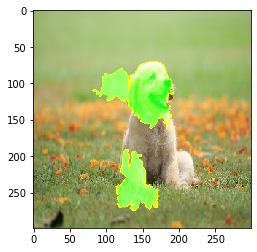

[('34', 0.166404414472205), ('36', 0.16442062907666122), ('29', 0.09527652234388811), ('32', 0.037726403553518494), ('55', 0.030199880293899372), ('39', -0.02873091488225209), ('27', 0.026730283483347127), ('47', 0.023080905260369183), ('50', 0.02065664106226162), ('21', 0.018824018509718907), ('48', 0.017598880840417296), ('41', 0.017457645928884307), ('44', 0.0170757956046086), ('7', 0.01631569668263234), ('53', 0.014956773038666663), ('35', 0.014480437912137073), ('57', 0.013617342528722607), ('33', 0.013572135816667033), ('40', -0.012831994228039685), ('2', 0.01193829459268641), ('12', 0.011653207375293234), ('25', -0.011288783069827384), ('15', 0.010971318180174236), ('52', 0.010956938904256202), ('10', 0.010486277337360692), ('61', -0.009747975359132615), ('60', 0.009647604453587182), ('1', 0.008888150470822986), ('23', -0.008851674699131422), ('11', -0.008788031119205104), ('56', -0.008586742736406815), ('46', 0.00853389513346453), ('16', 0.008291853289271778), ('51', -0.0080794

In [12]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

print(explanation.as_list(explanation.top_labels[0]))

#### Finally, we explain the top 1 label of the image _image[0]_ with BayLIME and with *partial* prior knowledge -- i.e. with option _model_regressor='BayesianRidge_inf_prior_fit_alpha'_ .

You will see, in this case, we fit the alpha from data and read the lambda parameter from the CSV file  './configure.csv'. Then, after the explanation, we will again write both the alpha and lambda parameters into the  './posterior_configure.csv' file.

the number of features: 63


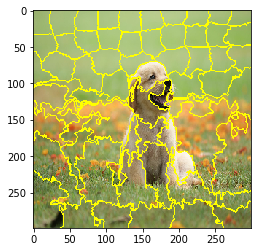


using Bay_info_prior_fixed_lambda_fit_alpha option for model regressor
Convergence after  2  iterations
the alpha is 155.02743952773625
the lambda is 20.0
the regulation term lambda/alpha is 0.12900941962872167


In [13]:
explanation = explainer.explain_instance(images[0], inet_model.predict,
                                         top_labels=1, hide_color=0, batch_size=10,
                                         num_samples=200,model_regressor='BayesianRidge_inf_prior_fit_alpha')
#'non_Bay' 'Bay_non_info_prior' 'Bay_info_prior','BayesianRidge_inf_prior_fit_alpha'

The rest of the steps are the same as before (i.e. the case using the full prior knowledge...)

In [14]:
alpha_var=1
lambda_var=1
with open('./posterior_configure.csv') as csv_file:
    csv_reader=csv.reader(csv_file)
    line_count = 0
    for row in csv_reader:
        if line_count == 1:
            alpha_var=float(row[0])
            lambda_var=float(row[1])
        line_count=line_count+1

In [15]:
explanation=calculate_posteriors.get_posterior(explanation,'.\data\prior_knowledge_5_jpg.csv',
                                               hyper_para_alpha=alpha_var,
                                               hyper_para_lambda=lambda_var,
                                               label=explanation.top_labels[0])

For feature of segment 36
The mean of the (posterior) coefficient 0.1359540500284685
The variance of the (posterior) coefficient 0.00034525746465040357
For feature of segment 29
The mean of the (posterior) coefficient 0.10085958924556127
The variance of the (posterior) coefficient 0.00033644936089497206
For feature of segment 34
The mean of the (posterior) coefficient 0.0860892306503841
The variance of the (posterior) coefficient 0.000375711612669473
For feature of segment 32
The mean of the (posterior) coefficient 0.07926209750376736
The variance of the (posterior) coefficient 0.00038937753057719546
For feature of segment 53
The mean of the (posterior) coefficient 0.07480035241837796
The variance of the (posterior) coefficient 0.00037954747769527916


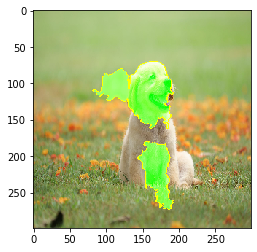

[('36', 0.1359540500284685), ('29', 0.10085958924556127), ('34', 0.0860892306503841), ('32', 0.07926209750376736), ('53', 0.07480035241837796), ('11', 0.059411086202652695), ('5', 0.05096652425682439), ('46', 0.048345058341616474), ('61', 0.047234122532130565), ('30', -0.044604084319553206), ('28', 0.04317231291199476), ('31', -0.04140990789131878), ('52', -0.04004098804704386), ('41', 0.03982369039399071), ('33', 0.03960142602497849), ('2', 0.037726233495530934), ('22', 0.03712670524144416), ('4', 0.03555231163491994), ('60', -0.03402159626873378), ('45', -0.0332299933914398), ('20', 0.032952526970077625), ('9', -0.03281227721753852), ('62', 0.03254409369740155), ('12', 0.032322545128091386), ('0', -0.03168602235345985), ('47', 0.031015181926726604), ('10', -0.03041239883074517), ('8', 0.030253438615887807), ('24', 0.03024885948164989), ('7', -0.028889149299271177), ('38', 0.028330008653383656), ('6', -0.027022919515519023), ('19', 0.026410008689478258), ('57', 0.02604205988338368), (

In [16]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

print(explanation.as_list(explanation.top_labels[0]))